In [10]:
import pandas as pd
from glob import glob
import cv2
import numpy as np
from sys import argv
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
import pickle
import tensorflow as tf
import tensorflow.keras as keras

In [11]:
path='/media/anil/Data/data/subsetSubCellular'
def load_files(path):
	list_dir=glob(path+str('/*/'))
	list_dir.sort()
	file_list={}
	for i in range(len(list_dir)):
		file_list[i + 1]=glob(list_dir[i]+str('/*.png'))
	df=pd.DataFrame(list(file_list.items()))
	fl=df[1]
	images=[]
	label=[]
	for i in range(len(fl)):
		ls=fl[i]
		for j in range(len(ls)):
			images.append(cv2.imread(ls[j]))
			label.append(i)
	images=np.asarray(images)
	label=np.asarray(label)
	return images,label

In [12]:
images,labels=load_files(path)

In [13]:
label_names={0:'Cytoplasm', 1:'Endosome', 2:'ER', 3:'Golgi', 4:'Mitochondrian', 5:'Nuclear Periphery',
		6:'Nucleolus', 7:'Nucleus', 8:'Peroxisome', 9:'Spindle Pole', 10:'Vacuole'}

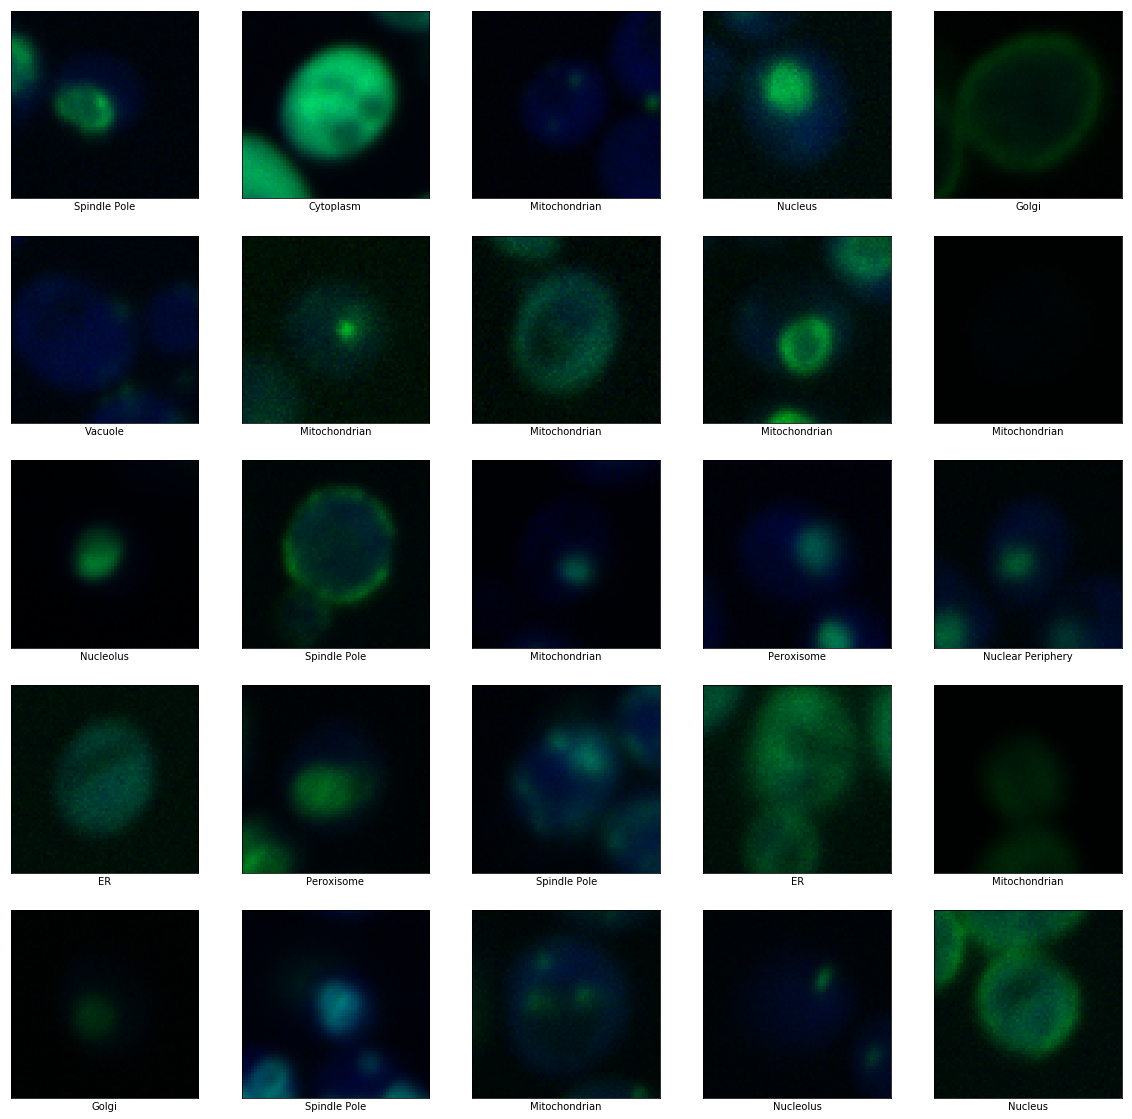

In [14]:
#To view images and their respective labels
rand_ind=np.random.randint(0,1100,25)
plt.figure(figsize=(20,20))
for i in range(len(rand_ind)):
	plt.subplot(5,5,i+1)
	plt.xticks([])
	plt.yticks([])
	plt.grid(False)
	plt.imshow(images[rand_ind[i]],cmap=plt.cm.binary)
	plt.xlabel(label_names[labels[rand_ind[i]]])

plt.show()

In [15]:
images,labels=shuffle(images,labels,random_state=42)
classes = np.unique(labels)
nClasses = len(classes)
X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size = 0.2, random_state=42)

In [16]:
rows,cols,dims=X_train.shape[1:]

# Change to float datatype
train_data = X_train.astype('float32')
test_data = X_test.astype('float32')

# Scale the data to lie between 0 to 1
train_data /= 255
test_data /= 255

# Change the labels from integer to categorical data
train_labels_one_hot = keras.utils.to_categorical(y_train)
test_labels_one_hot = keras.utils.to_categorical(y_test)

In [17]:
def createModel():
    model=keras.models.Sequential()
    model.add(keras.layers.Conv2D(64,(3,3),padding='same',activation='relu',input_shape=(rows,cols,dims)))
    model.add(keras.layers.Conv2D(64,(3,3),activation='relu'))
    model.add(keras.layers.MaxPooling2D(pool_size=(2,2)))
    model.add(keras.layers.Dropout(0.25))
    
    model.add(keras.layers.Conv2D(128,(3,3),padding='same',activation='relu'))
    model.add(keras.layers.Conv2D(128,(3,3),padding='same',activation='relu'))
    model.add(keras.layers.MaxPooling2D(pool_size=(2,2)))
    model.add(keras.layers.Dropout(0.25))
    
    model.add(keras.layers.Conv2D(256,(3,3),padding='same',activation='relu'))
    model.add(keras.layers.Conv2D(256,(3,3),padding='same',activation='relu'))
    model.add(keras.layers.Conv2D(256,(3,3),padding='same',activation='relu'))
    model.add(keras.layers.Conv2D(256,(3,3),padding='same',activation='relu'))
    model.add(keras.layers.MaxPooling2D(pool_size=(2,2)))
    model.add(keras.layers.Dropout(0.25))
    
    model.add(keras.layers.Flatten())
    model.add(keras.layers.Dense(512,activation='relu'))
    model.add(keras.layers.Dropout(0.25))
    model.add(keras.layers.Dense(512,activation='relu'))
    model.add(keras.layers.Dropout(0.25))
    model.add(keras.layers.Dense(512,activation='relu'))
    model.add(keras.layers.Dropout(0.25))
    model.add(keras.layers.Dense(nClasses,activation='softmax'))
    
    return model

In [18]:
model=createModel()
batch_size=40
epochs=20
model.compile(optimizer='rmsprop',loss='categorical_crossentropy',metrics=['accuracy'])

model.summary()

history=model.fit(train_data,train_labels_one_hot,batch_size=batch_size,epochs=epochs,verbose=1,validation_data=(test_data,test_labels_one_hot))
model.evaluate(test_data,test_labels_one_hot)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_8 (Conv2D)            (None, 64, 64, 64)        1792      
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 62, 62, 64)        36928     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 31, 31, 64)        0         
_________________________________________________________________
dropout_6 (Dropout)          (None, 31, 31, 64)        0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 31, 31, 128)       73856     
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 31, 31, 128)       147584    
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 15, 15, 128)       0         
__________

[2.414226783405651, 0.05909090929410674]

Text(0.5,1,'Loss Curves')

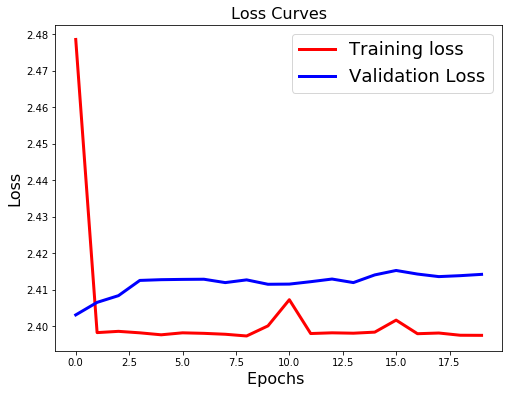

In [19]:
plt.figure(figsize=[8,6])
plt.plot(history.history['loss'],'r',linewidth=3.0)
plt.plot(history.history['val_loss'],'b',linewidth=3.0)
plt.legend(['Training loss', 'Validation Loss'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Loss',fontsize=16)
plt.title('Loss Curves',fontsize=16)

Text(0.5,1,'Accuracy Curves')

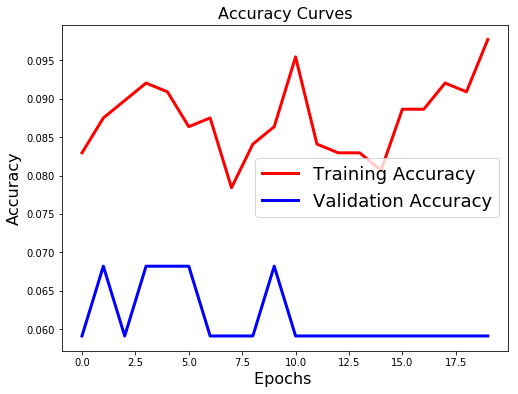

In [20]:
plt.figure(figsize=[8,6])
plt.plot(history.history['acc'],'r',linewidth=3.0)
plt.plot(history.history['val_acc'],'b',linewidth=3.0)
plt.legend(['Training Accuracy', 'Validation Accuracy'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Accuracy',fontsize=16)
plt.title('Accuracy Curves',fontsize=16)